# EXPLORATION 16 : 흐린 사진을 선명하게

## 준비한 데이터

- SR에 사용할 이미지 파일들
- SR에 사용할 GIF 파일들

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 프로젝트 1-1
1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. cv2.resize()를 사용해 봅시다.
3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.
5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(1279, 1920, 3)


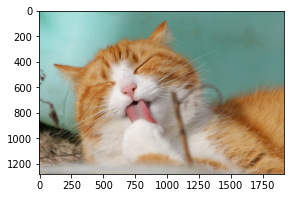

In [2]:
# 고해상도 이미지 불러오기
hr_image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/image/1.jpg')
hr_image = cv2.cvtColor(hr_image, cv2.COLOR_BGR2RGB)

print(hr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(hr_image)

(319, 480, 3)


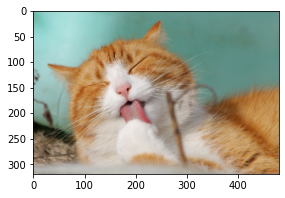

In [3]:
# 이미지 픽셀 수 줄이기 (1/4)
lr_image = cv2.resize(
    hr_image,
    dsize=(hr_image.shape[1]//4, hr_image.shape[0]//4)
)

print(lr_image.shape)

plt.figure(figsize=(6,3))
plt.imshow(lr_image)

In [4]:
# pre-trained 모델 로드
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
# SRGAN으로 고해상도 이미지 생성
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)  # 텐서 값을 지정된 최소값과 최대값으로 자릅니다.
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True      # as_supervised=True 옵션을 주면 dict 형태가 아닌 tuple 형태로 데이터를 return 받습니다.
)

for i, (lr, hr) in enumerate(valid):
    if i == 6: break

srgan_hr = apply_srgan(lr_image)

In [6]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    lr_image, 
    dsize=(hr_image.shape[1], hr_image.shape[0]), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

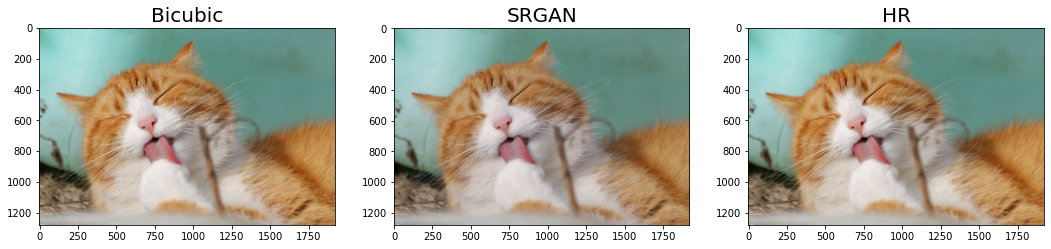

In [7]:
# 시각화
images = [bicubic_hr, srgan_hr, hr_image]
titles = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

In [8]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=100):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

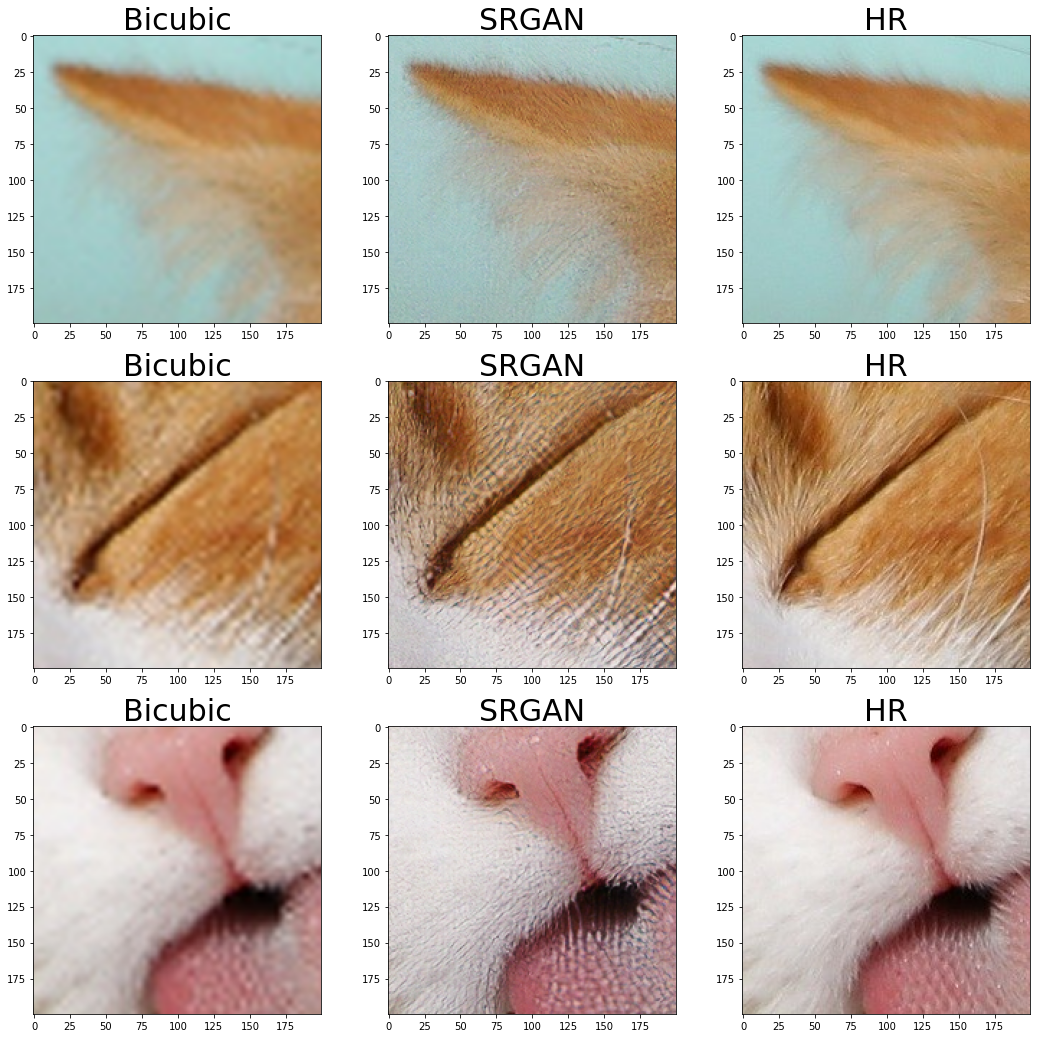

In [9]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(400,100), (350,720), (600,600)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(hr_image, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

Bicubic 보간법을 사용한 이미지는 전반적으로 SRGAN 보다 선명하지 않게 나왔고  
SRGAN을 이용하여 만든 이미지는 원본을 모른채로 보면 엄청 선명하다고 느낄만큼 성능이 좋지만  
바로 옆에 원본과 비교를 해보면 원본에 가깝게 복원을 하기보다는 스스로 선명하게 창조해낸 느낌이 든다.
위의 눈, 귀, 코와 입 세 이미지를 비교했을때 SRGAN이 전부 선명은 하지만 색감 자체는 Bicubic이 HR에 오히려 더 가깝다.

### 프로젝트 1-2
1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.
2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.
3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. cv2.resize()를 사용해 봅시다.
4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.
5. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

(426, 640, 3)


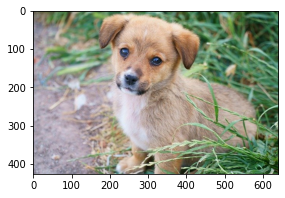

In [10]:
# 저해상도 이미지 불러오기
image = cv2.imread(os.getenv('HOME') + '/aiffel/super_resolution/image/2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image.shape)

plt.figure(figsize=(6,3))
plt.imshow(image)

In [11]:
# SRGAN으로 고해상도 이미지 생성
srgan_hr = apply_srgan(image)

In [12]:
# bicubic interpolation으로 이미지 사이즈 키우기
bicubic_hr = cv2.resize(
    image, 
    dsize=(image.shape[1]*4, image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

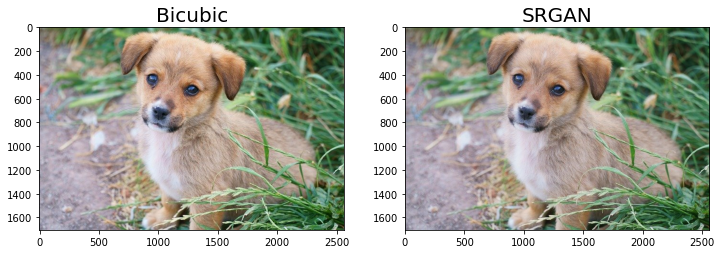

In [13]:
# 시각화
images = [bicubic_hr, srgan_hr]
titles = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,5))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

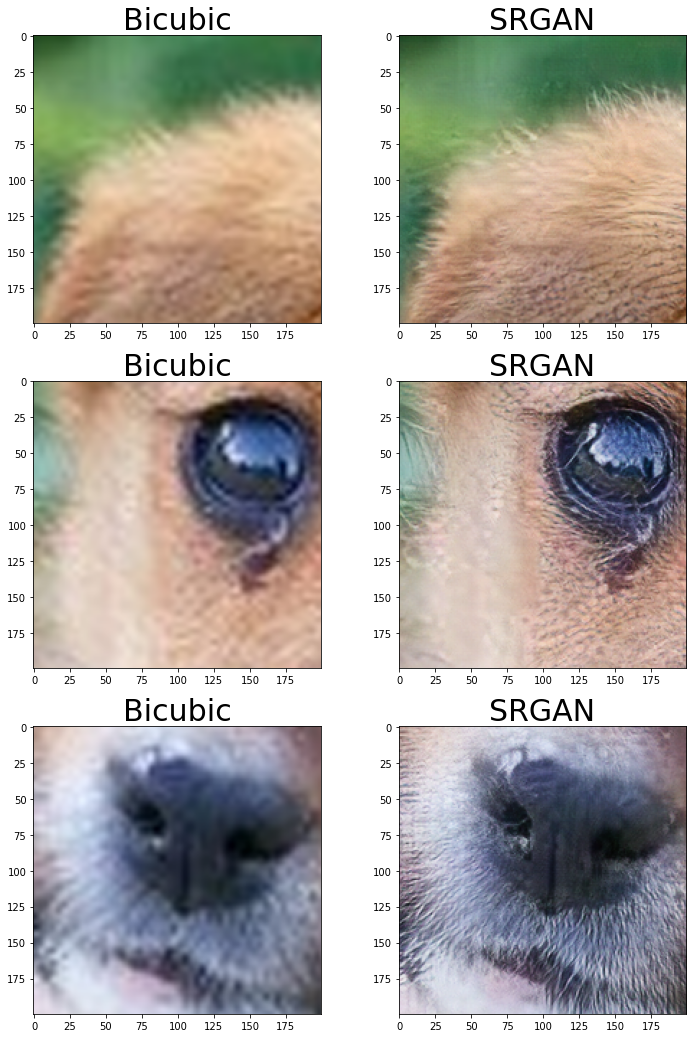

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(0,700), (380,800), (650,900)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(12,18))
for i in range(6):
    plt.subplot(3,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

이번 프로젝트는 저해상도 파일을 불러왔으므로 비교할 원본 파일이 없어서 그런지  
확실하게 SRGAN이 Bicubic 보간법에 비해서 우수하다는게 드러난다.  
눈, 코, 귀부분의 털 모두 SRGAN이 훨씬 선명하게 해상도를 높였다.

## 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### gif 파일 불러오기

In [15]:
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/gif'
gif = cv2.VideoCapture(os.path.join(gif_path, 'cat_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 13
frame 크기 : (480, 384, 3)


![cat_lr](/EXPLORATION/Exploration_16/GIF/cat_lr.gif)

### 프레임별 Super Resolution 진행하기

In [16]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

In [17]:
frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

### 프레임을 합쳐 gif 만들기

In [18]:
import imageio
from IPython.display import Image as show_gif

imageio.mimsave(os.path.join(gif_path, 'cat_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'cat_hr_srgan.gif'), frames_sr_srgan)

### 만들어진 gif 결과

| BICUBIC | SRGAN |
| :---: | :---: |
| ![BICUBIC](/EXPLORATION/Exploration_16/GIF/cat_hr_bicubic.gif) | ![SRGAN](/EXPLORATION/Exploration_16/GIF/cat_hr_srgan.gif) |

### 다른 gif 파일로 해보기

In [19]:
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/gif'
gif = cv2.VideoCapture(os.path.join(gif_path, 'dog_lr.gif'))

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 11
frame 크기 : (236, 500, 3)


![dog_lr](/EXPLORATION/Exploration_16/GIF/dog_lr.gif)

In [20]:
frames_sr_bicubic = []
for frame in frames:
    frames_sr_bicubic.append(cv2.resize(
        frame, 
        dsize=(frame.shape[1]*4, frame.shape[0]*4), 
        interpolation=cv2.INTER_CUBIC
    ))

frames_sr_srgan = []
for frame in frames:
    frames_sr_srgan.append(apply_srgan(frame))

imageio.mimsave(os.path.join(gif_path, 'dog_hr_bicubic.gif'), frames_sr_bicubic)
imageio.mimsave(os.path.join(gif_path, 'dog_hr_srgan.gif'), frames_sr_srgan)

### 만들어진 gif 결과

| BICUBIC | SRGAN |
| :---: | :---: |
| ![BICUBIC](/EXPLORATION/Exploration_16/GIF/dog_hr_bicubic.gif) | ![SRGAN](/EXPLORATION/Exploration_16/GIF/dog_hr_srgan.gif) |

멈춰있는 이미지처럼 확대를 해볼 수 없어서 BICUBIC과 SRGAN이 디테일하게 차이가 크게 나는지 알수는 없지만  
원본 작은 크기의 gif 파일을 크게 늘렸는데도 화질이 비슷하게 보이고 BICUBIC과 SRGAN 사이에 색감에 차이만 조금 있는 것 같다.  

# 프로젝트 결과
딥러닝을 이용한 Super Resolution이라는 기술이 보간법으로 단순하게 해상도를 올리는 것보다  
더 좋다는 것을 이미지 사진을 확대해서 비교함으로써 제대로 이해하게 되었다.  
이 기술을 잘 발전시키면 범죄수사 드라마에서 흔히 나오는 CCTV 영상을 통해 얼굴 부분을 확대하고  
사람의 얼굴을 인식해서 신원을 파악하는 꿈같은 기술이 현실이 될 수도 있지 않을까 생각이 들었다.